If you haven't heard by now [JAX](https://jax.readthedocs.io/en/latest/index.html) is getting a lot of attention online as a "[NumPy on steroids](https://iaml.it/blog/jax-intro-english)".  At it's core, it can be thought of as a drop-in replacement for [NumPy](https://numpy.org/) where the array calculations can be accelerated on GPUs or TPUs when available.  This alone makes it worth looking at, especially if you have a lot of NumPy code that you would like to potentially speed up with GPU acceleration.  Currently, most of the [NumPy API is implemented](https://jax.readthedocs.io/en/latest/jax.numpy.html) in one-to-one correspondence, as well of some of the most used functions in [SciPy](https://jax.readthedocs.io/en/latest/jax.scipy.html).

The accelerated NumPy is just the beginning of the utility of JAX.  All of the JAX NumPy data structures can be used in combination with most pure Python code to create functions which can be automatically differentiated.  This includes computing the gradient of scalar functions, as well as Jacobian matrices of vector functions.  These operations can be composed to compute gradients-of-gradients, etc.  More information of the automatic differentiation capabilities are documented [here](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html).

Additionally, there is a built-in [just-in-time compiler](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#Using-jit-to-speed-up-functions) for compiling functions to be executed on CPUs/GPUs/TPUs, and support for [automatic vectorization](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#Auto-vectorization-with-vmap), i.e. functions written for scalar arguments can be easily mapped across arrays.  These can be used with the automatic differentiation functions previously mentioned.

Finally, there is a very thin neural network library associated with JAX called [stax](https://jax.readthedocs.io/en/latest/jax.experimental.stax.html).  Other, more fully-featured libraries like [Haiku](https://github.com/deepmind/dm-haiku), [Flax](https://github.com/google/flax), or [Trax](https://github.com/google/trax) are under development on top of JAX technologies.

In what follows, I'll highlight most of these features of JAX by implementing a finite element analysis (FEA) model and then using the finite element residual as part of the objective function when training a neural network in an inverse solution to a potentially unknown constitutive model.

## Problem definition

As a model problem, we'll start with the one-dimensional pressure diffusivity equation which governs single phase fluid flow in a porous media with fluid density $\rho$ and small compressibility $c$.

$$
\rho c \frac{\partial p}{\partial t} = \frac{\partial}{\partial x}\left(\frac{\kappa}{\mu} \frac{\partial p}{\partial x}\right)
$$

Assuming steady state, multiplying by a test function $\delta p$ on the left and integrating by parts over the domain $(0, L)$ we have 

\begin{align}
0 =& \int_0^L \lambda(x) \frac{\partial \left(\delta p\right)}{\partial x} \frac{\partial p}{\partial x} \textrm{d}x - \left[ \lambda(x)  \frac{\partial p}{\partial x} \right]_0^L \\
  =& \int_0^L \lambda(x) \frac{\partial \left(\delta p\right)}{\partial x} \frac{\partial p}{\partial x} \textrm{d}x - \left[ q \right]_0^L
\end{align}

where

$$
\lambda(x) = \frac{\kappa}{\mu},
$$

$\kappa$ is the porous medium's permeability and $\mu$ is the fluid viscosity.  $\lambda$ is known as the *mobility* and is assumed to be spatially varying.  

Using a Galerkin appoximation, i.e. $p = N_J p_J$ and $\delta p = N_I$ for $I,J = 1, 2, \ldots$ basis functions and splitting the domain into $n$ intervals, we now have

\begin{align}
  0 =& \sum_{k=0}^n p_J \left(\int_{x_k}^{x_{k+1}} \lambda(x) \frac{\partial N_I}{\partial x} \frac{\partial N_J}{\partial x} \textrm{d}x  - \left[ q \right]_{x_k}^{x_{k+1}} \right)
\end{align}

where summation over the $J$ basis functions are implied for those that have support on the $I^{th}$ node.  The right-hand side above is our residual, i.e. $\vec{R}$

\begin{align}
  R_I \equiv \sum_{k=0}^n p_J \left(\int_{x_k}^{x_{k+1}} \lambda(x) \frac{\partial N_I}{\partial x} \frac{\partial N_J}{\partial x} \textrm{d}x  - \left[ q \right]_{x_k}^{x_{k+1}} \right)
\end{align}

below, we'll integrate this residual vector using Gauss integration and solve for the unknown nodal pressures $p_J$.  Without loss of generality we'll only consider Dirchelet boundary conditions, i.e. $q(x) = 0$.

While this model problem is linear, we'll implement the FEA model to use the residual form of the equations, and solve for the unknowns using a nonlinear Newton-Raphson solver where the Jacobian matrix at each iteration is computed via automatic-differentiation with JAX.  All of the computations are written in a way that they could be accelerated on GPUs/TPUs and are just-in-time compiled.

## FEA implementation

Below are the imports we need, note that we explicitly enable 64-bit floating point numbers for JAX as 32-bit is the default.

In [1]:
from functools import partial, partialmethod

import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, value_and_grad, random, flatten_util
import jax.numpy as jnp
import jax.scipy.optimize
import jax.ops
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
class FEAProblem():


    def __init__(self, nodes, mobility=lambda x: 1, left_bc=1.0, right_bc=-1.0):
        """FEAProblem class
           
        Args:
        
            nodes (array-like): nodal spatial locations of unknowns
            mobility (callable): function defining the mobility function 
                                 in space
            left_bc (real): Dirchelet boundary on the left of the domain 
            right_bc (real): Dirchelet boundary on the right of the domain 
        """
    

        self.nodes = jnp.array(nodes, dtype='float64')
        self.connect = jnp.array([ jnp.arange(i,i+2) 
                                   for i in range(self.nodes.shape[0] - 1)])
        self.__lbc = left_bc
        self.__rbc = right_bc
        self.mobility = mobility
        
        return


    def setup_element_matrices(self):
        """Integrates the element stiffness matrices for linear basis functions
           with 2 points Guass integration
        """
        
        nodes = self.nodes
        
        #We will use Gauss integration at the following points
        t1 =  np.sqrt(1.0 / 3.0)
        t2 = -np.sqrt(1.0 / 3.0)
        
        # Because the points above are defined on the domain -1 < x < 1 and our
        # elements are defined on arbitrary domains, we can use a change of 
        # variables to rescale the integration bounds
        ξ1 = ((nodes[1:] - nodes[:-1]) * t1 + nodes[1:] + nodes[:-1]) / 2.0
        ξ2 = ((nodes[1:] - nodes[:-1]) * t2 + nodes[1:] + nodes[:-1]) / 2.0
        
        # Compute the function 𝜆, at the integration points
        𝜆ξ1 = self.mobility(ξ1)
        𝜆ξ2 = self.mobility(ξ2)
        
        # Since the derivatives of the shape functions are not dependent on ξ, 
        # we can # create an array containing all of the element stiffness 
        # matrices at once
        dNdξ = jnp.array([1 / (nodes[:-1] - nodes[1:]), 
                          1 / (nodes[1:] - nodes[:-1])])
        # Computes the matrix dN_i * dN_j for every element (each will be 
        # identical for equally spaced nodes)
        ke_temp = jnp.einsum('i...,j...', dNdξ, dNdξ)
        
        # Now we perform the Gauss integration computing the integrand for each 
        # element
        temp = (nodes[1:] - nodes[:-1]) / 2 * (𝜆ξ1 + 𝜆ξ2)
        
        # We have to add two axis so the broadcasting is performed correctly,
        # the result here is the fully integrated element matrix array
        self.ke = temp[:, None, None] * ke_temp
        
        return


    @partial(jit, static_argnums=(0,))
    def residual(self, p):
        """Compute the FE residual vector
        
        Args:
            p (array-like): possible solution to residual equations
            
        Returns:
            (array-like): the residual vector
        """
        
        nodes = self.nodes
        connect = self.connect
        ke = self.ke
        
        # Initialize the residual 
        res = jnp.zeros_like(nodes)
        
        # Compute the residual, i.e. sum all of the element
        # matrices with the nodal values, p
        res_temp = jnp.einsum('...ij, ...j', ke, p[connect]).flatten()
        
        # This is the JAX equivalent of
        # res[-1:1] = ...,  i.e. in place assignment
        res = res.at[1:-1].set(res_temp[1:-1].reshape(-1, 2).sum(axis=1))
        # Fix the residual values at the boundaries
        res = res.at[0].set(p[0] - self.__lbc)
        res = res.at[-1].set(p[-1] - self.__rbc)
        
        return res


    @partial(jit, static_argnums=(0,))
    def loss(self, p):
        """Compute the loss function, i.e. the 
           l2 norm of the residual vector.
           
        Args:
            p (array-like): possible solution to the residual equations
            
        Returns:
            (real): discrete 2-norm of residual vector
        """
        return jnp.linalg.norm(self.residual(p))


    @partial(jit, static_argnums=(0,))
    def newton_step(self, p):
        """Compute one step of a Newton-Raphson iteration, uses
           JAX to compute the exact Jacobian via automatic differentiation
           
        Args:
            p (array-like): possible solution to the residual equations
        
        Returns:
            p (array-like): updated solution to the residual equations after
                          a single Newton-Raphson step
        """
        
        # The jacobian
        K = jax.jacfwd(self.residual)(p)
        
        # Compute the update direction 
        Δp, _ = jax.scipy.sparse.linalg.gmres(lambda x: -K @ x, 
                                              self.residual(p))
        
        # Update the unknowns and return 
        p += Δp
        
        return p


    @partial(jit, static_argnums=(0,))
    def solve(self, tolerance=1.0e-4):
        """ Solve via Newton-Raphson iteration 
        
        Args:
            tolerance (float): the tolerence at which the Newton-Raphson 
                               iteration stops
        
        Returns:
            p (array-like): the converged solution to the residual equations
        """
        
        # Integrate the shape functions over each element
        self.setup_element_matrices()
        
        # Initial guess is linear between the boundary conditions
        p = jnp.linspace(self.__lbc, self.__rbc, num=self.nodes.shape[0])
        
        # The Newton-Raphson loop, can be compiled and automatically 
        # differentiated 
        p = jax.lax.while_loop(lambda x: self.loss(x) > tolerance, 
                               self.newton_step, p)

        # Return the solution
        return p

## Generate reference data

Below we'll solve the forward problem via FEA using the implementation above to verify things are working correctly as well as generate some reference data that we'll use in the inverse problem in the sequal.  Here, the mobility function is

$$
\lambda(x) = x^3 + 0.001
$$

In [3]:
nodes = jnp.linspace(0, 1, num=20)
problem1 = FEAProblem(nodes, mobility = lambda x: x ** 3 + 0.001, 
                      left_bc=15, right_bc=5)
p1 = problem1.solve(tolerance=1.0e-4)

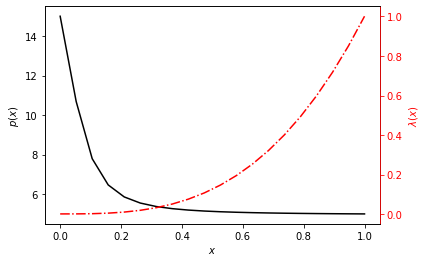

In [4]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(nodes, p1, 'k')
ax2.plot(nodes, nodes ** 3 + 0.001, 'r-.')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$p(x)$', color='k');
ax2.set_ylabel(r'$\lambda(x)$', color='r');
ax2.tick_params(axis='y', colors='r')
ax2.spines['right'].set_color('r')

## Inverse problem implementation

Here we will write our inverse problem solver.  We will inherit from the `FEAProblem` class above so we can reuse some of the functions already defined.

Our objective function here will be the $l_2$-norm of the finite element residual when the "known data" is supplied as training data.  Because the problem we are solving is a steady-state problem, we'll need to provide the endpoints of constitutive model to the objective function, otherwise there are infinite valid solutions to learning the constitutive model that only differ by a constant.  If we extended this technique to time-dependent problems, I believe the need to provide the boundary constraints can be avoided.

We'll use a few functions from the `jax.experimental.stax` module, just to make the neural network construction easier.  Our minimizer here will use the second-order `"BFGS"` method from `jax.scipy.optimize.minimize`.

Here we assume our data is supplied at the nodes of the FE model, but this restriction could be easily generalized by evaluating the residuals at any given spatial location via the FE shape functions.

In [5]:
from jax.experimental import stax
from jax.experimental.stax import Dense, Tanh
from jax.nn.initializers import glorot_normal, normal

In [6]:
class InverseProblem(FEAProblem):
   
    def __init__(self, nodes, mobility = stax.serial(Dense(1)), 
                 mobility_left_bc=0.001, mobility_right_bc=1.001):
        """Class to solve for (i.e. learn) the constitutive model of 
           the steady-state pressure diffusivity equation using a 
           neural network (nn).
           
        Args:
            nodes (array-like): the spatial locations corresponding to the 
                                data points
            mobility (stax.nn): a stax neural network definition
            mobility_left_bc (real): the left boundary value of the 
                                     mobility function
            mobility_right_bc (real): the right boundary value of the 
                                      mobility function
        """
        super().__init__(nodes, mobility = mobility)
        
        self.__mlbc = mobility_left_bc
        self.__mrbc = mobility_right_bc
        
        # unpack the functions to initialize and apply the network parameters
        net_init, self.net_apply = self.mobility
        
        # initialize the network parameters with random numbers
        seed = random.PRNGKey(10)
        _, net_params = net_init(seed, (-1, 1))
        
        # flatten the nn parameters into an single array
        self.initial_net_params_flat, self.unravel_pytree = flatten_util.ravel_pytree(net_params)
    
    @partial(jit, static_argnums=(0,))
    def residual(self, u, data):
        """Compute the FE residual vector 
        
        Args:
            u (array-like): the unknown parameters of the nn
            data (array-like): the user supplied data (i.e. pressures) 
                               at the nodes
            
        Returns:
            (array-like): residual vector
        """
        
        # Put the parameters back into the stax nn data structure 
        net_params = self.unravel_pytree(u)
        
        # Set the mobility function to be the current nn
        self.mobility = lambda x: self._predict(x, net_params)
        mobility = self.mobility(self.nodes)
        
        # Integrate the element shape functions with the current
        # mobility function
        self.setup_element_matrices()
        
        # Return the FE residual vector with the supplied data
        return super().residual(data)
    
    @partial(jit, static_argnums=(0,))
    def loss(self, u, data):
        """Compute the squared error of the FE residual vector 
           along with the mobility at the end points
           
        Args:
            u (array-like): the unknown parameters of the nn
            data (array-like): the user supplied data (i.e. pressures) at 
                               the nodes
            
        Returns:
            (real): squared error of the FE residual and mobility function 
                    end points
        """
        
        # Compute FE residual with supplied data
        residual = self.residual(u, data)
        
        # Put the unknowns back into the stax nn data structure
        net_params = self.unravel_pytree(u)
        
        # Use the nn parameters to compute the mobility at the nodes 
        mobility = self._predict(nodes, net_params)
        
        # Compute squared error norm of mobility end points
        mobility_squared_error = ((mobility[0] - self.__mlbc) ** 2 + 
                                  (mobility[-1] - self.__mrbc) ** 2)
        
        # Return FE + mobility squared error
        return jnp.linalg.norm(residual) ** 2 + mobility_squared_error
    
    @partial(jit, static_argnums=(0,))
    def fit(self, data):
        """Fit the parameters of the neurual network representing the mobility
           function
           
        Args:
            data (array-like): known pressure data at the nodal locations
        """
        
        self.__lbc = data[0]
        self.__rbc = data[-1]
        
        u0 = self.initial_net_params_flat
        
        # minimize the loss function w.r.t. the uknown parameters of the nn
        u = jit(lambda u, data: jax.scipy.optimize.minimize(self.loss, u,  
                                                            args=(data,), 
                                                            method='BFGS').x)(u0, data)
        
        # assign the final nn params, such that we can use if for predicting 
        self.net_params = self.unravel_pytree(u)
            
        return
        
    @partial(jit, static_argnums=(0,))
    def _predict(self, x, params):
        """Used internal to the class only - evaluates the nn function 
           at x with the given parameters
        """
        return vmap(partial(self.net_apply, params))(x).flatten()
    
    @partial(jit, static_argnums=(0,))
    def predict(self, x):
        """Evaluates the nn function at x with the fit parameters
        
        Args:
            x (array-like): spatial locations to evalute the neural network
        """
        return self._predict(x, self.net_params)

## Solve inverse problem using NN

Below we'll test out our inverse problem solver using the data generated earlier from the forward finite element solution.  First we define our neural network architecture.  This is a fairly simple function, so we don't need a large and/or complex neural network.  Here we have an input layer with only 4 nodes and a $\tanh$ activation function feeding to a single node output.  More complicated architectures also work, yielding the same result at more computational cost.

We also need to define the layer `Dense64` which is the same as `stax.Dense`, but initialized to use 64-bit floats to be consistant with our data structures in the FEA residual calculation.

In [7]:
Dense64 = lambda x: Dense(x, W_init=glorot_normal(dtype='float64'), 
                             b_init=normal(dtype='float64'))

nn = stax.serial(
    Dense64(4), Tanh,
    Dense64(1)
)

Now we instantiate the model and solve the inverse problem, i.e. train the network.  We do have to supply the endpoints of the constitutive model.  Given the problem is parabolic, there are infinite solutions to the inverse problem (they all have the same shape, but differ by a constant scale factor).  We could remove this restriction by considering a time-dependent problem and supplying the time depended training data which we'll leave for future work.

In [8]:
iproblem1 = InverseProblem(nodes, mobility = nn, 
                           mobility_left_bc = 0.001, mobility_right_bc = 1.001)
iproblem1.fit(p1)

Plotting the neural network function over the range of the domain and comparing with the reference, we can see that the inverse solver has "learned" the mobility function well.

UnexpectedTracerError: Encountered an unexpected tracer. Perhaps this tracer escaped through global state from a previously traced function.
The functions being transformed should not save traced values to global state. Detail: tracer created on line <ipython-input-6-9274fe1e335d>:31 (__init__).

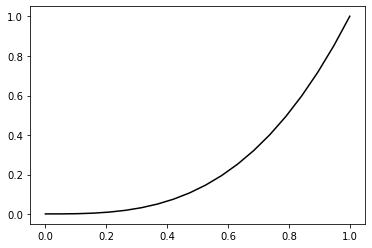

In [9]:
x = nodes 
fig, ax = plt.subplots()
ax.plot(x, x ** 3 + 0.001, 'k-')
ax.plot(x, iproblem1.predict(x), 'r-.')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\lambda(x)$');
ax.legend([r'$\lambda(x) = x^3 + 0.001$', r'$\lambda(x) = \mathcal{NN}(x)$']);

## Use the trained NN in the forward problem (verification)

Just to verify, we'll use our neural network as the mobility function in our forward finite element solver to demonstrate the resulting pressures are also accurate.

In [ ]:
vproblem1 = FEAProblem(nodes, mobility = iproblem1.predict, 
                       left_bc=15, right_bc=5)
v1 = vproblem1.solve()
fig, ax = plt.subplots()
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p(x)$');
ax.plot(nodes, p1, 'k-');
ax.plot(nodes, v1, 'r-.');
ax.legend([r'$\lambda(x) = x^3 + 0.001$', r'$\lambda(x) = \mathcal{NN}(x)$']);

## Validate for different BCs

A major advantage of this approach over say, physics-informed neural networks, is that we have only "learned" the constitutive model, i.e. the mobility function, not the solution of the partial differential equation with the supplied boundary conditions.  Instead, we rely on our finite element implementation to compute the solution.  Which means we can now use our "learned" constitutive model to solve problems with different boundary conditions accurately.

In [ ]:
problem2 = FEAProblem(nodes, mobility = lambda x: x ** 3 + 0.001, 
                      left_bc=5, right_bc=20)
p2 = problem2.solve(tolerance=1.0e-4)
problem3 = FEAProblem(nodes, mobility = iproblem1.predict, 
                      left_bc=5, right_bc=20)
p3 = problem3.solve(tolerance=1.0e-4)
fig, ax = plt.subplots()
ax.plot(nodes, p2, 'k-');
ax.plot(nodes, p3, 'r-.');
ax.legend([r'$\lambda(x) = x^3 + 0.001$', r'$\lambda(x) = \mathcal{NN}(x)$']);

## License

Copyright 2021 John T. Foster

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

>https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.